Processing 15 files from session 1

Calculating total size and checking consistency...


  7%|▋         | 1/15 [00:01<00:17,  1.25s/it]


Processing 10_20151014.mat with prefix 'tyc_eeg'
Found 62 channels in first segment


 13%|█▎        | 2/15 [00:02<00:16,  1.25s/it]


Processing 11_20150916.mat with prefix 'whh_eeg'


 20%|██        | 3/15 [00:03<00:14,  1.22s/it]


Processing 12_20150725.mat with prefix 'wll_eeg'


 27%|██▋       | 4/15 [00:04<00:13,  1.23s/it]


Processing 13_20151115.mat with prefix 'wq_eeg'


 33%|███▎      | 5/15 [00:06<00:12,  1.23s/it]


Processing 14_20151205.mat with prefix 'zjd_eeg'


 40%|████      | 6/15 [00:07<00:11,  1.23s/it]


Processing 15_20150508.mat with prefix 'zjy_eeg'


 47%|████▋     | 7/15 [00:08<00:09,  1.23s/it]


Processing 1_20160518.mat with prefix 'cz_eeg'


 53%|█████▎    | 8/15 [00:09<00:08,  1.23s/it]


Processing 2_20150915.mat with prefix 'ha_eeg'


 60%|██████    | 9/15 [00:11<00:07,  1.24s/it]


Processing 3_20150919.mat with prefix 'hql_eeg'


 67%|██████▋   | 10/15 [00:12<00:06,  1.30s/it]


Processing 4_20151111.mat with prefix 'ldy_eeg'


 73%|███████▎  | 11/15 [00:13<00:05,  1.32s/it]


Processing 5_20160406.mat with prefix 'ly_eeg'


 80%|████████  | 12/15 [00:15<00:03,  1.32s/it]


Processing 6_20150507.mat with prefix 'mhw_eeg'


 87%|████████▋ | 13/15 [00:16<00:02,  1.29s/it]


Processing 7_20150715.mat with prefix 'mz_eeg'


 93%|█████████▎| 14/15 [00:17<00:01,  1.27s/it]


Processing 8_20151103.mat with prefix 'qyt_eeg'


100%|██████████| 15/15 [00:19<00:00,  1.27s/it]



Processing 9_20151028.mat with prefix 'rx_eeg'

Total timesteps across all segments: 10305360
Number of channels: 62

Allocating array...

Concatenating segments...


100%|██████████| 15/15 [00:22<00:00,  1.52s/it]



Saving concatenated data to session1_raw_eeg_full.npy
Final array shape: (62, 10305360)

Data statistics:
Mean: -0.0189
Std: 110.1214
Min: -35856.7539
Max: 123472.8125


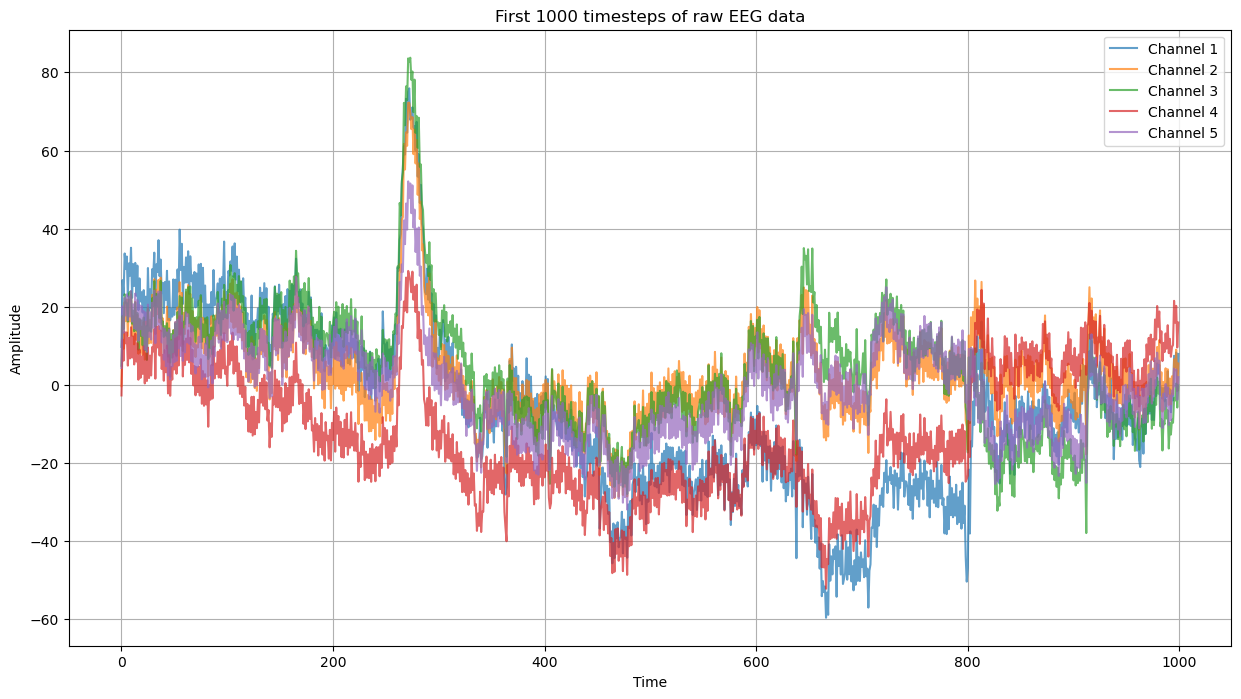

In [2]:
import os
import numpy as np
import scipy.io as sio
from tqdm import tqdm

def concatenate_raw_eeg_files(session_id=1, N=None, save_path='session1_raw_eeg.npy'):
    """
    Load and concatenate all EEG segments from N files in a session.
    """
    session_dir = f"seed_iv/eeg_raw_data/{session_id}"
    files = sorted([f for f in os.listdir(session_dir) if f.endswith('.mat')])
    
    if N is not None:
        files = files[:N]
    
    print(f"Processing {len(files)} files from session {session_id}")
    
    # First pass: calculate total length and verify channel consistency
    total_timesteps = 0
    n_channels = None
    file_segment_info = []  # Store information about segments for metadata
    
    print("\nCalculating total size and checking consistency...")
    for file in tqdm(files):
        try:
            mat_data = sio.loadmat(os.path.join(session_dir, file))
        except Exception as e:
            print(f"\nError loading {file}: {str(e)}")
            continue
            
        file_segments = []
        
        # Find the EEG prefix by looking at the first key that ends with 'eeg1'
        eeg_prefix = None
        for key in mat_data.keys():
            if key.endswith('eeg1'):
                eeg_prefix = key[:-1]  # Remove the '1' to get the prefix
                break
        
        if not eeg_prefix:
            print(f"\nWarning: Could not find EEG prefix in {file}")
            print("Available keys:", [k for k in mat_data.keys() if not k.startswith('__')])
            continue
            
        # Get all EEG segment keys with the correct prefix
        eeg_keys = sorted([k for k in mat_data.keys() if k.startswith(eeg_prefix)])
        
        print(f"\nProcessing {file} with prefix '{eeg_prefix}'")
        
        for key in eeg_keys:
            try:
                data = mat_data[key]
                
                # Check/set number of channels
                if n_channels is None:
                    n_channels = data.shape[0]
                    print(f"Found {n_channels} channels in first segment")
                elif data.shape[0] != n_channels:
                    print(f"Warning: Inconsistent channels in {file}:{key}. Expected {n_channels}, got {data.shape[0]}")
                    continue
                
                total_timesteps += data.shape[1]
                file_segments.append({
                    'key': key,
                    'timesteps': data.shape[1]
                })
            except Exception as e:
                print(f"\nError processing segment {key} in {file}: {str(e)}")
                continue
        
        if file_segments:
            file_segment_info.append({
                'file': file,
                'prefix': eeg_prefix,
                'segments': file_segments
            })
    
    if not file_segment_info:
        raise ValueError("No valid data found in any files")
    
    print(f"\nTotal timesteps across all segments: {total_timesteps}")
    print(f"Number of channels: {n_channels}")
    
    # Allocate the full array
    print("\nAllocating array...")
    full_data = np.zeros((n_channels, total_timesteps), dtype=np.float32)
    
    # Second pass: concatenate all segments
    current_pos = 0
    print("\nConcatenating segments...")
    for file_info in tqdm(file_segment_info):
        try:
            mat_data = sio.loadmat(os.path.join(session_dir, file_info['file']))
            
            for segment in file_info['segments']:
                data = mat_data[segment['key']]
                timesteps = data.shape[1]
                full_data[:, current_pos:current_pos + timesteps] = data
                current_pos += timesteps
        except Exception as e:
            print(f"\nError processing file {file_info['file']}: {str(e)}")
            continue
    
    # Trim any unused space if some segments were skipped
    if current_pos < total_timesteps:
        print(f"\nWarning: Only filled {current_pos}/{total_timesteps} timesteps")
        full_data = full_data[:, :current_pos]
    
    # Save the concatenated array
    print(f"\nSaving concatenated data to {save_path}")
    print(f"Final array shape: {full_data.shape}")
    np.save(save_path, full_data)
    
    # Save metadata
    metadata = {
        'files': files,
        'n_channels': n_channels,
        'total_timesteps': current_pos,
        'file_segment_info': file_segment_info
    }
    np.save(save_path.replace('.npy', '_metadata.npy'), metadata)
    
    return full_data, metadata

# Run the concatenation for all files in session 1
data, metadata = concatenate_raw_eeg_files(session_id=1, N=None, save_path='session1_raw_eeg_full.npy')

# Print some statistics about the data
print("\nData statistics:")
print(f"Mean: {data.mean():.4f}")
print(f"Std: {data.std():.4f}")
print(f"Min: {data.min():.4f}")
print(f"Max: {data.max():.4f}")

# Plot a small segment of the data for a few channels
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
for i in range(min(5, data.shape[0])):  # Plot first 5 channels
    plt.plot(data[i, :1000], label=f'Channel {i+1}', alpha=0.7)
plt.title('First 1000 timesteps of raw EEG data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

## Visualize

In [3]:
# # Plot a small segment of the data for a few channels with interactive scrolling
# import matplotlib.pyplot as plt
# import ipywidgets as widgets
# from IPython.display import display

# def plot_eeg_segment(start_time):
#     seconds = 10
#     plt.figure(figsize=(15, 8))
#     start_idx = int(start_time * 1000)
#     end_idx = start_idx + seconds * 1000
    
#     for i in range(min(5, data.shape[0])):  # Plot first 5 channels
#         plt.plot(data[i, start_idx:end_idx], label=f'Channel {i+1}', alpha=0.7)
    
#     plt.title(f'EEG data from {start_time}s to {start_time + seconds}s')
#     plt.xlabel('Time (samples)')
#     plt.ylabel('Amplitude')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Calculate maximum time in seconds
# max_time = data.shape[1] / 1000 - 10  # Subtract window size to prevent overflow

# # Create slider widget
# time_slider = widgets.FloatSlider(
#     value=0,
#     min=0,
#     max=max_time,
#     step=1.0,
#     description='Start Time (s):',
#     continuous_update=False
# )

# # Display interactive plot
# widgets.interactive(plot_eeg_segment, start_time=time_slider)

## Normalize

Normalization statistics:
95th percentiles shape: (62, 1)

Per-channel 95th percentiles:
Channel 1: 107.1990
Channel 2: 103.8015
Channel 3: 102.6690
Channel 4: 64.1048
Channel 5: 58.1741

After normalization:
Mean: -0.0004
Std: 2.2051
Min: -978.8011
Max: 1926.1088


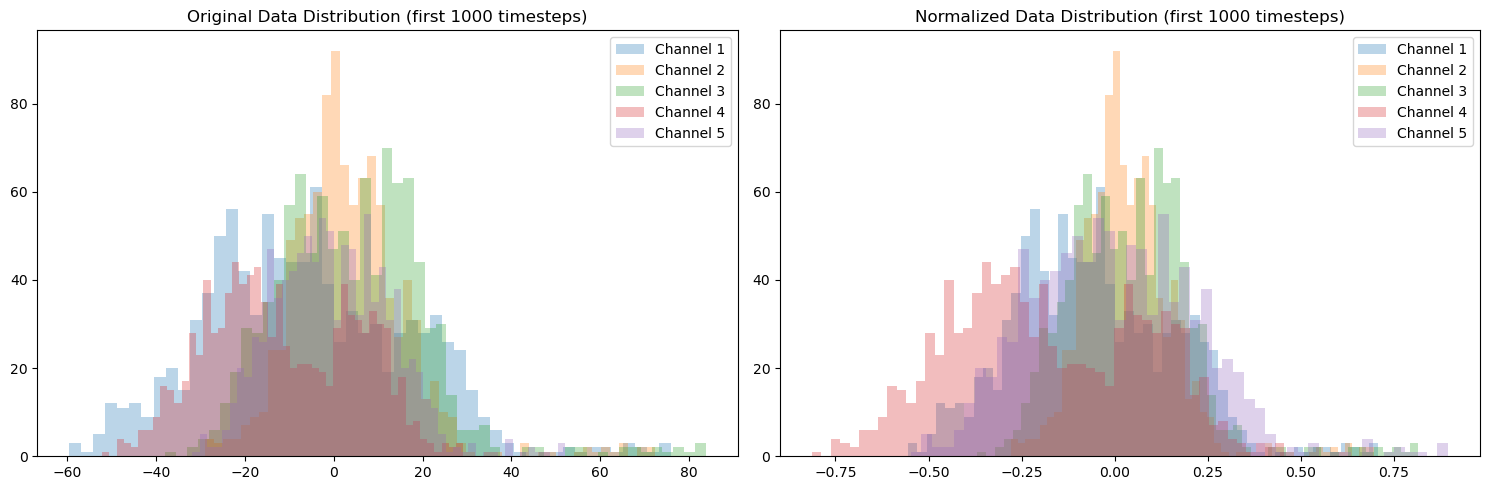

In [4]:
def normalize_by_95th_percentile(data):
    """
    Normalize each channel by its 95th percentile.
    
    Args:
        data: numpy array of shape (n_channels, n_timesteps)
    
    Returns:
        normalized_data: numpy array of same shape, normalized per channel
    """
    # Calculate 95th percentile for each channel
    percentile_95 = np.percentile(np.abs(data), 95, axis=1, keepdims=True)
    
    # Avoid division by zero
    percentile_95[percentile_95 == 0] = 1.0
    
    # Normalize
    normalized_data = data / percentile_95
    
    print("Normalization statistics:")
    print(f"95th percentiles shape: {percentile_95.shape}")
    print("\nPer-channel 95th percentiles:")
    for i in range(min(5, data.shape[0])):  # Print first 5 channels
        print(f"Channel {i+1}: {percentile_95[i, 0]:.4f}")
    
    print("\nAfter normalization:")
    print(f"Mean: {normalized_data.mean():.4f}")
    print(f"Std: {normalized_data.std():.4f}")
    print(f"Min: {normalized_data.min():.4f}")
    print(f"Max: {normalized_data.max():.4f}")
    
    # Plot before and after distributions for a few channels
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    for i in range(min(5, data.shape[0])):
        plt.hist(data[i, :1000], bins=50, alpha=0.3, label=f'Channel {i+1}')
    plt.title('Original Data Distribution (first 1000 timesteps)')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i in range(min(5, data.shape[0])):
        plt.hist(normalized_data[i, :1000], bins=50, alpha=0.3, label=f'Channel {i+1}')
    plt.title('Normalized Data Distribution (first 1000 timesteps)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return normalized_data

# Normalize the data
normalized_data = normalize_by_95th_percentile(data)

## Save


Reshaping data into 1030 segments of 10 seconds...


100%|██████████| 1030/1030 [00:01<00:00, 669.96it/s]



Segmented data shape: (1030, 62, 10000)

Shuffling segments...

Split sizes:
Train: (721, 62, 10000) (70.0%)
Validation: (206, 62, 10000) (20.0%)
Test: (103, 62, 10000) (10.0%)

Saving splits...

Done! Files saved in seed_iv/session1


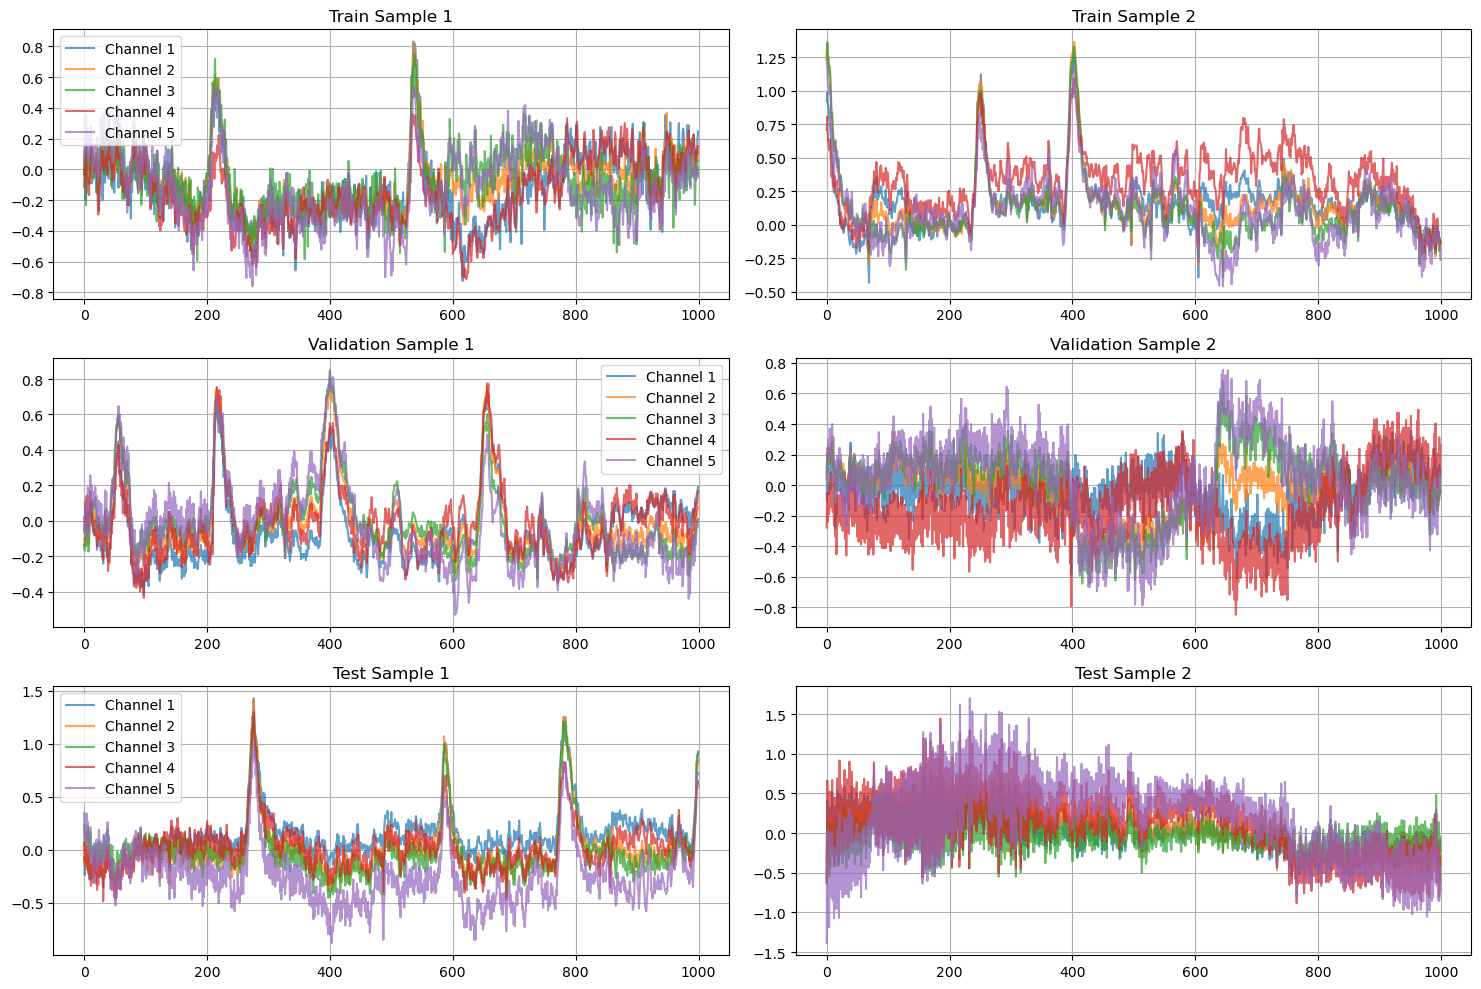

In [5]:
import os
import numpy as np
from tqdm import tqdm

def split_and_save_data(data_normalized, sample_length_sec=10, sample_rate=1000, 
                       splits=[0.7, 0.2, 0.1], save_dir='seed_iv/session1'):
    """
    Split normalized data into fixed-length segments and save train/val/test sets.
    
    Args:
        data_normalized: numpy array of shape (n_channels, n_timesteps)
        sample_length_sec: length of each sample in seconds
        sample_rate: sampling rate in Hz
        splits: list of proportions for [train, val, test]
        save_dir: directory to save the numpy arrays
    """
    n_channels, n_timesteps = data_normalized.shape
    samples_per_segment = sample_length_sec * sample_rate
    
    # Calculate number of complete segments
    n_segments = n_timesteps // samples_per_segment
    
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Reshape data into segments
    print(f"\nReshaping data into {n_segments} segments of {sample_length_sec} seconds...")
    segments = np.zeros((n_segments, n_channels, samples_per_segment))
    
    for i in tqdm(range(n_segments)):
        start_idx = i * samples_per_segment
        end_idx = start_idx + samples_per_segment
        segments[i] = data_normalized[:, start_idx:end_idx]
    
    print(f"\nSegmented data shape: {segments.shape}")
    
    # Calculate split indices
    n_train = int(n_segments * splits[0])
    n_val = int(n_segments * splits[1])
    n_test = n_segments - n_train - n_val
    
    # Shuffle the segments
    print("\nShuffling segments...")
    rng = np.random.default_rng(42)  # Set random seed for reproducibility
    shuffle_idx = rng.permutation(n_segments)
    segments = segments[shuffle_idx]
    
    # Split into train/val/test
    train_data = segments[:n_train]
    val_data = segments[n_train:n_train+n_val]
    test_data = segments[n_train+n_val:]
    
    print("\nSplit sizes:")
    print(f"Train: {train_data.shape} ({train_data.shape[0]/n_segments:.1%})")
    print(f"Validation: {val_data.shape} ({val_data.shape[0]/n_segments:.1%})")
    print(f"Test: {test_data.shape} ({test_data.shape[0]/n_segments:.1%})")
    
    # Save splits
    print("\nSaving splits...")
    np.save(os.path.join(save_dir, 'train.npy'), train_data)
    np.save(os.path.join(save_dir, 'validation.npy'), val_data)
    np.save(os.path.join(save_dir, 'test.npy'), test_data)
    
    # Save split metadata
    metadata = {
        'n_segments': n_segments,
        'sample_length_sec': sample_length_sec,
        'sample_rate': sample_rate,
        'splits': splits,
        'shapes': {
            'train': train_data.shape,
            'validation': val_data.shape,
            'test': test_data.shape
        }
    }
    np.save(os.path.join(save_dir, 'split_metadata.npy'), metadata)
    
    print("\nDone! Files saved in", save_dir)
    return metadata

# Split and save the normalized data
metadata = split_and_save_data(normalized_data)

# Plot a few samples from each split to verify
def plot_split_samples(save_dir, n_samples=2, n_channels=5):
    splits = ['train', 'validation', 'test']
    plt.figure(figsize=(15, 10))
    
    for i, split in enumerate(splits):
        data = np.load(os.path.join(save_dir, f'{split}.npy'))
        
        for j in range(n_samples):
            plt.subplot(len(splits), n_samples, i*n_samples + j + 1)
            for c in range(n_channels):
                plt.plot(data[j, c, :1000], alpha=0.7, label=f'Channel {c+1}' if j == 0 else '')
            plt.title(f'{split.capitalize()} Sample {j+1}')
            if j == 0:
                plt.legend()
            plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot samples from each split
plot_split_samples('seed_iv/session1')